In [258]:
import pandas as pd
import numpy as np
import torch
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random
import os
import time
from ta import add_all_ta_features

In [259]:
'''for f in os.listdir('stocks'):
    if os.path.getsize('stocks/'+f)<7000:
        os.remove('stocks/'+f)
for f in os.listdir('etfs'):
    if os.path.getsize('etfs/'+f)<7000:
        os.remove('etfs/'+f)'''

"for f in os.listdir('stocks'):\n    if os.path.getsize('stocks/'+f)<7000:\n        os.remove('stocks/'+f)\nfor f in os.listdir('etfs'):\n    if os.path.getsize('etfs/'+f)<7000:\n        os.remove('etfs/'+f)"

In [260]:
l1=os.listdir('stocks')
l2=os.listdir('etfs')
device=torch.device('cuda:0')

In [261]:
def lin_reg(df): #feature neutralization to 1st order
    reg = linear_model.LinearRegression()
    reg.fit(df[:,6:],df[:,:5])
    return reg.predict(df[:,6:])

In [262]:
def generate(path):
    df=pd.read_csv(path).filter(['Open','High','Low','Close','Adj Close','Volume'])
    df=df.dropna()
    df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    df=np.array(df)
    neutralized = lin_reg(df)
    df[:,:5] -= neutralized
    df=df[:-1]-df[1:]
    transprices=RobustScaler().fit(df[:,:5])
    df[:,:5]=transprices.transform(df[:,:5])
    maxprice=np.max(np.abs(df[:,:5]))
    maxvol=np.max(np.abs(df[:,5]))
    df[:,:5] /= maxprice
    df[:,5] /= maxvol
    for x in range(6,df.shape[1]):
        transinc=RobustScaler().fit(df[:,x].reshape(-1,1))
        df[:,x]=transinc.transform(df[:,x].reshape(-1,1))[:,0] #transform indicator
    df[:,6:] /= np.max(np.abs(df[:,6:]),0)
    np.nan_to_num(df,False,0,1,-1)
    return df,maxprice,maxvol,transprices,neutralized

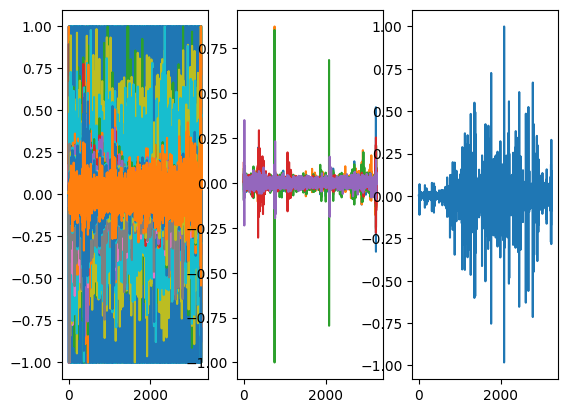

In [263]:
random.shuffle(l1)
random.shuffle(l2)
test_path = 'etfs/'+l2[0]
df,maxprice,maxvol,transa,neutralized = generate(test_path)
fig,ax = plt.subplots(1,3)
ax[0].plot(df)
ax[1].plot(df[:,:5])
ax[2].plot(df[:,5])
plt.show()

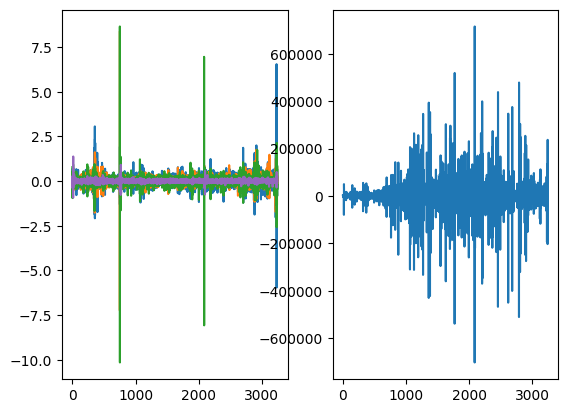

In [264]:
#restoring
def restorePreds(d,maxprice,maxvol,transa):
    df=d.copy()
    df[:,:5]=transa.inverse_transform(df[:,:5]*maxprice)
    df[:,5]=df[:,5]*maxvol
    return df
df=restorePreds(df,maxprice,maxvol,transa)
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:5])
ax[1].plot(df[:,5])
plt.show()

In [265]:
def create(dataset,lback,lforward=1):
    X,y=[],[]
    for i in range(len(dataset)-lback-lforward+1):
        X.append(np.array(dataset[i:i+lback]))
        y.append(np.array(dataset[i+1:i+lback+lforward]))
    return torch.tensor(np.array(X)).float(),torch.tensor(np.array(y)).float()

In [266]:
lback=50
X_train,y_train=create(df,lback=lback)

PHASE 1a1: LSTM PREDICTION

In [267]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm=nn.LSTM(input_size=92,hidden_size=200,num_layers=2,dropout=0.1,batch_first=True)
        self.l1=nn.Linear(200,92)
    def forward(self,x):
        x,_=self.lstm(x)
        x=self.l1(x)
        return x

In [268]:
model=LSTMModel()
model.to(device)

LSTMModel(
  (lstm): LSTM(92, 200, num_layers=2, batch_first=True, dropout=0.1)
  (l1): Linear(in_features=200, out_features=92, bias=True)
)

In [269]:
def l2loss(y_pred,y):
    return torch.mean(torch.square(y_pred-y))

In [270]:
def signloss(y_pred,y):
    #return torch.ceil(-y_pred[:,:,:5]*y[:,:,:5])
    return -torch.mean(torch.clip(y[:,:,:5]*y_pred[:,:,:5],0)*torch.abs(y[:,:,:5]))

In [271]:
def extloss(y_pred,y):
    return torch.square(torch.mean(torch.abs(y)-torch.abs(y_pred)))

In [272]:
def lstmloss(y_pred,y):
    l2 = l2loss(y_pred,y)*3
    sign = signloss(y_pred,y)
    ext = extloss(y_pred,y)
    #return torch.clip(2*(l2+sign),max=.5)
    return torch.clip(l2*(1+sign+ext),max=.5)

In [273]:
def train(n_epochs,dl,lforward=1):
    optimizer=torch.optim.Adam(model.parameters(),lr=1e-3/lforward)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5/lforward, max_lr=1e-3/lforward,step_size_up=10000,mode="triangular2",cycle_momentum=False)
    for i in range(n_epochs):
        for X,y in dl:
            y = y.to(device)
            logits = 0
            y_pred = model(X.to(device))
            logits += lstmloss(y_pred,y[:,:lback])
            for j in range(1,lforward):
                y_pred = model(y_pred)
                logits += lstmloss(y_pred,y[:,j:j+lback])
            logits = logits/lforward
            optimizer.zero_grad()
            logits.backward()
            optimizer.step()
            scheduler.step()
    print(logits)
    torch.save(model.state_dict(),'lstmmodel.pt')

In [274]:
model.train()
for i in l2[:100]:
    a='etfs/'+i
    df,_,_,_,_=generate(a)
    X_train,y_train=create(df,lback=lback)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(1,dl)

tensor(0.0554, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0592, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0421, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0502, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0575, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0455, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0561, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0341, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0507, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0581, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0596, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0524, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1587, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0560, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0391, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0554, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0572, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0747, device='cuda:0', grad_fn=<DivBack

C:\Users\reiner\AppData\Local\Temp\ipykernel_20688\2155909266.py:18: RuntimeWarning: invalid value encountered in divide
  df[:,6:] /= np.max(np.abs(df[:,6:]),0)


tensor(0.0968, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0464, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0556, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0449, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0454, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0434, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0499, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0568, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1014, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0530, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0431, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0578, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0598, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0470, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0495, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0367, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0460, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0466, device='cuda:0', grad_fn=<DivBack

PHASE 1a2: LSTM STAGE 2 (>1 PREDICTION)

In [275]:
'''model.train()
random.shuffle(l1);random.shuffle(l2)
for i in l2[:100]:
    a='etfs/'+i
    df,_,_,_,_=generate(a)
    X_train,y_train=create(df,lback=lback,lforward=10)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(5,dl,10)'''

"model.train()\nrandom.shuffle(l1);random.shuffle(l2)\nfor i in l2[:100]:\n    a='etfs/'+i\n    df,_,_,_,_=generate(a)\n    X_train,y_train=create(df,lback=lback,lforward=10)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(5,dl,10)"

In [276]:
model.load_state_dict(torch.load('lstmmodel.pt'))

<All keys matched successfully>

In [342]:
test_path='etfs/'+random.choice(l2)
print(test_path)

etfs/IBMQ.csv


In [352]:
model.eval() #NOT EVAL IN FINAL PREDICTIONS
df,a,b,transprices,neutralized = generate(test_path)
X_test,y_test = create(df, lback=lback)
dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), shuffle=False, batch_size=1)
qwer = True
for X,y in dl:
    if qwer:
        predicted = list(X.detach().numpy()[0])
        qwer = False
    predicted.append(model(X.to(device))[0][-1].detach().cpu().numpy())

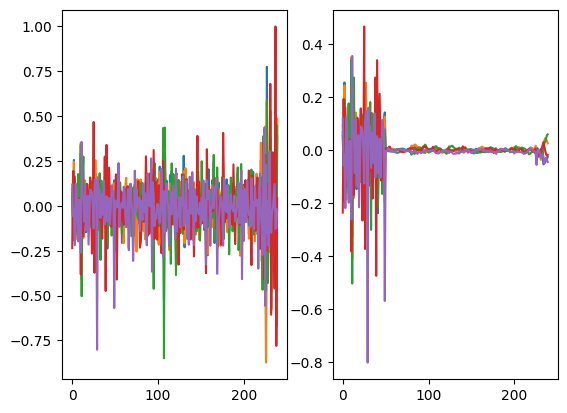

In [353]:
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:5])
ax[1].plot(np.array(predicted)[:,:5])
plt.show()

(241, 6)
[array([ 25.10000038,  25.10000038,  25.06500053,  25.06500053,
        24.74983406, 100.        ])]


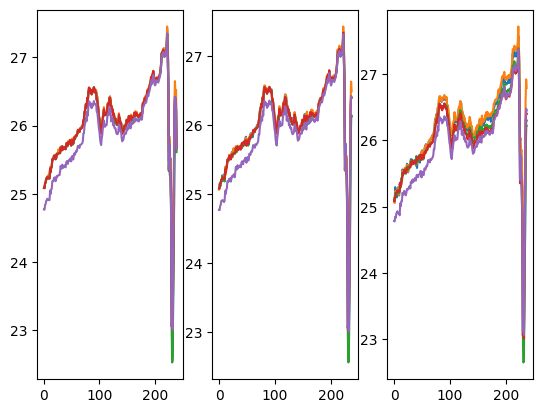

In [354]:
test_data=np.array(pd.read_csv(test_path).filter(['Open','High','Low','Close','Adj Close','Volume']))
print(test_data.shape)
fig,ax=plt.subplots(1,3)
ax[0].plot(test_data[1:,:5]) # original

predicted=np.array(predicted)
predicted=restorePreds(predicted,a,b,transprices)
test2=predicted[:,:5]+neutralized[:-1]
ax[1].plot(test2[1:-1]) # check that the transforms are correct, consider this 1 day preds

testult=[test_data[0]]
print(testult)
for i in range(predicted.shape[0]):
    testult.append(np.sum(predicted[:i+1],axis=0)[:6])
testult = np.array(testult)[:-1,:5]+neutralized[:-1]
ax[2].plot(np.array(testult)[1:-1,:5]) # results, cumulative error

In [355]:
def test_prep(arr):
    arr /= np.max(np.abs(arr))
    arr = arr[:-1]-arr[1:]
    return arr
test_data = test_prep(test_data[:-1,:5]) #original
test2 = test_prep(test2[:,:5]) #preds

pp=np.sum(np.ceil(test_data))
pn=np.sum(np.ceil(-test_data))
p=np.sum(np.ceil(test2))
n=np.sum(np.ceil(-test2))
tp=np.sum(np.ceil(test_data)*np.ceil(test2))
tn=np.sum(np.ceil(-test_data)*np.ceil(-test2))
recall=tp/p
precision=tp/pp
print('recall: ',recall)
print('precision: ',precision)
print('acc: ',(tp+tn)/(p+n))
print('f1: ',2*recall*precision/(recall+precision))

recall:  0.8356164383561644
precision:  0.9008438818565401
acc:  0.8535564853556485
f1:  0.867005076142132


PHASE 1b1: LGBM

In [282]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [283]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [284]:
p_data = pd.read_csv(test_path).filter(['Open','High','Low','Close','Adj Close','Volume'])

In [285]:
p_data,_,_,_,_=generate(test_path)
p_data = pd.DataFrame(p_data, columns = np.arange(p_data.shape[1]))
p_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
count,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,...,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000
mean,0.000506,0.000422,-0.000099,-0.000074,0.000773,0.000061,-0.002068,0.003517,0.000859,0.000484,...,0.002838,0.010160,0.005124,-0.022806,-0.019749,-0.015848,-0.004851,0.000930,0.000904,0.001620
std,0.032683,0.034831,0.033744,0.054134,0.023062,0.092937,0.079167,0.104913,0.118376,0.040350,...,0.137407,0.199104,0.165149,0.086814,0.130616,0.092993,0.054726,0.106511,0.102744,0.060305
min,-0.398096,-0.313167,-0.335842,-1.000000,-0.149289,-1.000000,-1.000000,-1.000000,-1.000000,-0.495475,...,-1.000000,-1.000000,-0.974741,-1.000000,-1.000000,-1.000000,-1.000000,-0.687049,-0.713700,-0.593929
25%,-0.013485,-0.014295,-0.014049,-0.015038,-0.013678,-0.024512,-0.020074,-0.031536,-0.052667,-0.006515,...,-0.082622,-0.110891,-0.094430,-0.046326,-0.087067,-0.042584,-0.011092,-0.061821,-0.059437,-0.027482
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.001039,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.014711,0.013901,0.014146,0.013158,0.014517,0.026797,0.018571,0.036201,0.055184,0.005635,...,0.086811,0.132050,0.103172,0.028442,0.071433,0.035071,0.006520,0.064706,0.062519,0.029686
max,0.509912,0.493606,0.463195,0.657895,0.213741,0.799335,0.808007,0.870088,0.932159,1.000000,...,0.884264,0.922829,1.000000,0.107461,0.232684,0.307122,0.351914,1.000000,1.000000,1.000000


In [286]:
total_start_time = time.time()

for col in p_data.columns:
    # Record start time for the column
    start_time = time.time()
    
    # Load data
    X = pd.DataFrame(p_data)
    y = pd.Series(p_data[col])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
    }

    # Train the model
    num_round = 100
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Make predictions
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Record end time for the column
    end_time = time.time()
    column_runtime = end_time - start_time
    
    print(f'===== Column "{col}" =====')
    print(f'Runtime: {column_runtime:.5f}s')
    print(f'RMSE: {rmse}')

# Calculate total runtime
total_end_time = time.time()
total_runtime = total_end_time - total_start_time
print(f'\nTotal runtime: {total_runtime:.5f}s')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's rmse: 0.0185566
===== Column "0" =====
Runtime: 0.09992s
RMSE: 0.018556625795723238
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's rmse: 0.0182977
===== Column "1" =====
Runtime: 0.09500s
RMSE: 0.018297690957337114
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's rmse: 0.00926232
===== Column "2" =====
Runtime: 0.09100s
RMSE: 0.009262319561227628
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 0.0112041
===== Column "3" =====
Runtime: 0.07800s
RMSE: 0.011204134684213924
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.00356991
===== Column "4" =====
Runtime: 0.09700